In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels as sm

# Custom functions
from utils import *

In [2]:
%load_ext autoreload
%autoreload 2

## ARIMA forecasting [DAILY]

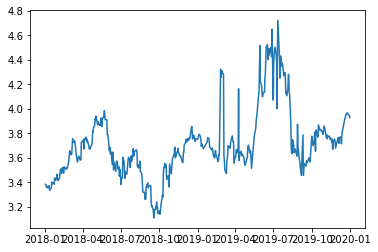

In [80]:
#Loading the data
corn_raw = pd.read_csv('data/corn.csv', header = 2)

# Process all of the data
CORN = process_data(corn_raw, 'CORN', start_date = '2018-01-01', end_date='2020-01-01') 

plt.plot(CORN.Date, CORN.CORN)

In [81]:
# One day ahead forecasting 

In [84]:
# Rolling window

training_days = 30

true_values = []
predicted_values = []
dates = []
for i in range(int(CORN.shape[0] / training_days)):
    training_df = CORN.iloc[i*training_days:(i+1)*training_days]
    test_df = CORN.iloc[(i+1)*training_days]
    
    #print(training_df.CORN)
    #Test with ARMA(1,1)
    model = ARIMA(training_df.CORN, order=(1,1,0))
    results = model.fit()
    one_step_ahead_forecast = results.get_forecast(1).summary_frame().iloc[0,0]
    
    true_values.append(test_df.CORN)
    predicted_values.append(one_step_ahead_forecast)
    dates.append(test_df.Date)
    

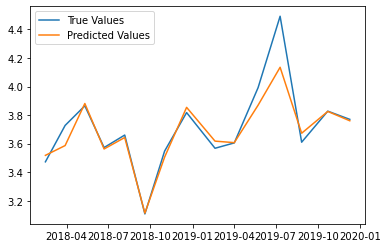

In [85]:
plt.plot(dates, true_values, dates, predicted_values)
plt.legend(["True Values", "Predicted Values"])